In [1]:
import numpy as np # Import numpy for numerical operations
import pandas as pd # # Import pandas for data manipulation, data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup # Import BeautifulSoup for HTML parsing
import re # Import re for regular expression operations
from sklearn.preprocessing import LabelBinarizer # Import for binary label transformations
from sklearn.feature_extraction.text import TfidfVectorizer # Import TF-IDF vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix # Import evaluation metrics
import matplotlib.pyplot as plt # Import matplotlib for plotting
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator # Import tools for creating word clouds
import plotly.express as px  # Import Plotly Express for interactive plotting

In [2]:
import warnings #Import warnings library to hide warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data from CSV file
movie_reviews = pd.read_csv('IMDB Dataset.csv')

In [4]:
# Display first few rows of data
movie_reviews.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [5]:
# Generate descriptive statistics
# Outputs include count (number of entries), unique (number of unique entries), top (most common entry), and freq (frequency of the top entry) for each column.
movie_reviews.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [6]:
# Count the occurrences of each sentiment
movie_reviews['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
# Function to remove HTML markup from text
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove text within square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Function to denoise text by removing HTML and text within square brackets
def clean_text(text):
    text = strip_html_tags(text)
    text = remove_between_square_brackets(text)
    return text

# Apply denoising function to review column
movie_reviews['review'] = movie_reviews['review'].apply(clean_text)

In [8]:
# Function to remove special characters from text
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function to clean special characters from reviews
movie_reviews['review'] = movie_reviews['review'].apply(remove_special_characters)

In [9]:
# Display the first few rows of the cleaned data
movie_reviews.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production The filming tech...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically theres a family where a little boy J...  negative
4  Petter Matteis Love in the Time of Money is a ...  positive

In [10]:
# Convert sentiment to binary labels
sentiment_encoder = LabelBinarizer()
movie_reviews['sentiment'] = sentiment_encoder.fit_transform(movie_reviews['sentiment'])

In [11]:
# Split data into training and testing sets
train_sentiment = movie_reviews.sentiment[:40000]
train_review = movie_reviews.review[:40000]
test_sentiment = movie_reviews.sentiment[40000:]
test_review = movie_reviews.review[40000:]

In [12]:
# Initialize and fit TF-IDF vectorizer:

In [13]:
# Initialize the TF-IDF vectorizer with specific parameters to control term frequency
# 'min_df' sets the minimum document frequency for terms to be included (terms must appear in at least 20 documents),
# 'max_df' limits terms to those occurring in no more than 50% of the documents to exclude too common terms,
# 'ngram_range' allows for both unigrams and bigrams in the feature set.
tf_vec = TfidfVectorizer(min_df=20, max_df=0.5, ngram_range=(1,2))

In [14]:
# Fit the TF-IDF vectorizer to the training data and transform the reviews into a TF-IDF matrix.
cv_train_review = tf_vec.fit_transform(train_review)

# Transform the test data reviews into a TF-IDF matrix using the already fitted vectorizer
cv_test_review = tf_vec.transform(test_review)

In [15]:
# Display the dimensions of the TF-IDF vectorized training and testing datasets to verify their size.
cv_train_review.shape, cv_test_review.shape

((40000, 60356), (10000, 60356))

In [16]:
# Initialize and train logistic regression model
lr = LogisticRegression()
trained_model = lr.fit(cv_train_review, train_sentiment)

In [17]:
# Print model performance:
# This returns a single value representing the model's accuracy as a decimal, where 1.0 indicates perfect accuracy and 0.5 indicates no better than random guessing.

In [18]:
# Output the accuracy of the model on the training data.
trained_model.score(cv_train_review, train_sentiment)

0.9455

In [19]:
# Output the accuracy of the model on the test data.
trained_model.score(cv_test_review, test_sentiment)

0.9032

In [20]:
# Predict and evaluate model:

In [21]:
# Use the trained logistic regression model to predict the sentiment of the test reviews.
predictions = trained_model.predict(cv_test_review)

# Store the actual sentiments of the test reviews for comparison.
actual = test_sentiment

In [22]:
# Display the confusion matrix to evaluate classification accuracy, detailing correct and incorrect predictions.
# Top-left: correct non-positive predictions
# Top-right: incorrect positive predictions
# Bottom-left: incorrect non-positive predictions
# Bottom-right: correct positive predictions
confusion_matrix(actual, predictions)

array([[4480,  513],
       [ 455, 4552]], dtype=int64)

In [23]:
# Calculate and display the overall accuracy of the model from the test predictions.
accuracy_score(actual, predictions)

0.9032

In [24]:
# Output a detailed classification report showing precision, recall, F1-score, and support for each sentiment class, along with overall accuracy and support.
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4993
           1       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [25]:
# Display the words with the greatest impact on sentiment from the logistic regression analysis:

In [26]:
# Construct a dictionary linking each word from the TF-IDF features to its logistic regression coefficient, indicating their impact on sentiment
feature_to_coef = {
    word: coef for word, coef in zip(
        tf_vec.get_feature_names_out(), trained_model.coef_[0]
    )
}

# Sort the dictionary items by coefficient value in descending order and print the top 5 words with the highest positive influence on sentiment.
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:5]:
    print (best_positive)

('great', 8.4478270547243)
('excellent', 6.372001151012828)
('perfect', 5.101751393724606)
('wonderful', 5.088940054771539)
('the best', 4.497881332055051)


In [27]:
# Sort the dictionary items by coefficient value in ascending order and print the top 5 words with the highest negative influence on sentiment.
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:5]:
    print (best_negative)


('bad', -9.241920236039533)
('worst', -8.438330445666775)
('awful', -7.044492033481656)
('the worst', -6.724906700667792)
('boring', -6.346469318937618)


In [28]:
# Generate word clouds for positive and negative words

In [29]:
pos_words=''
for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:100]:
    pos_words += str(best_positive)


In [30]:
neg_words=''
for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1])[:100]:
    neg_words += str(best_negative)

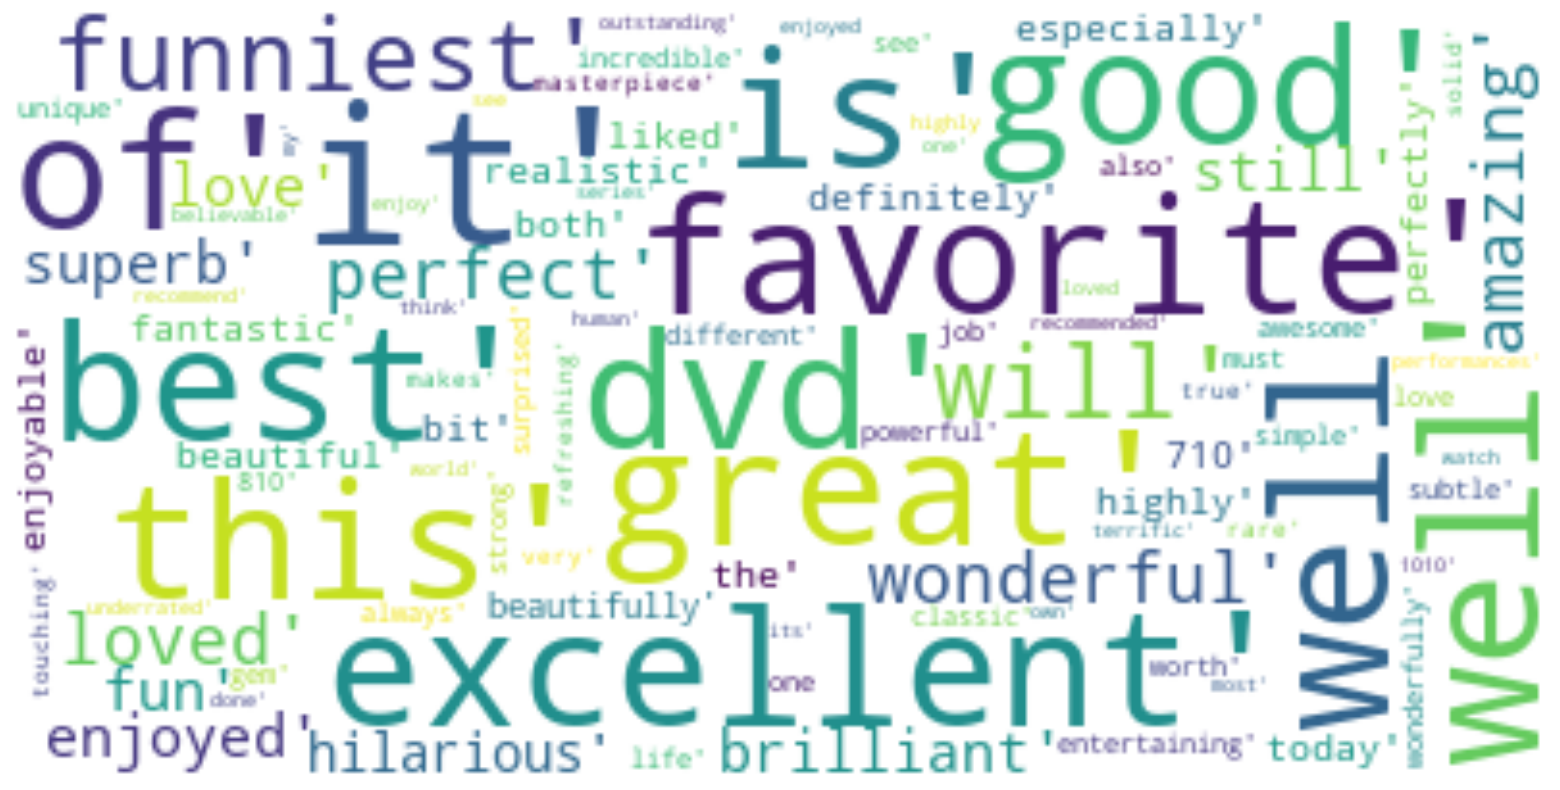

In [31]:
# Create and generate a word cloud image
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_words)

# Display the generated image
plt.figure(figsize=(20,10))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

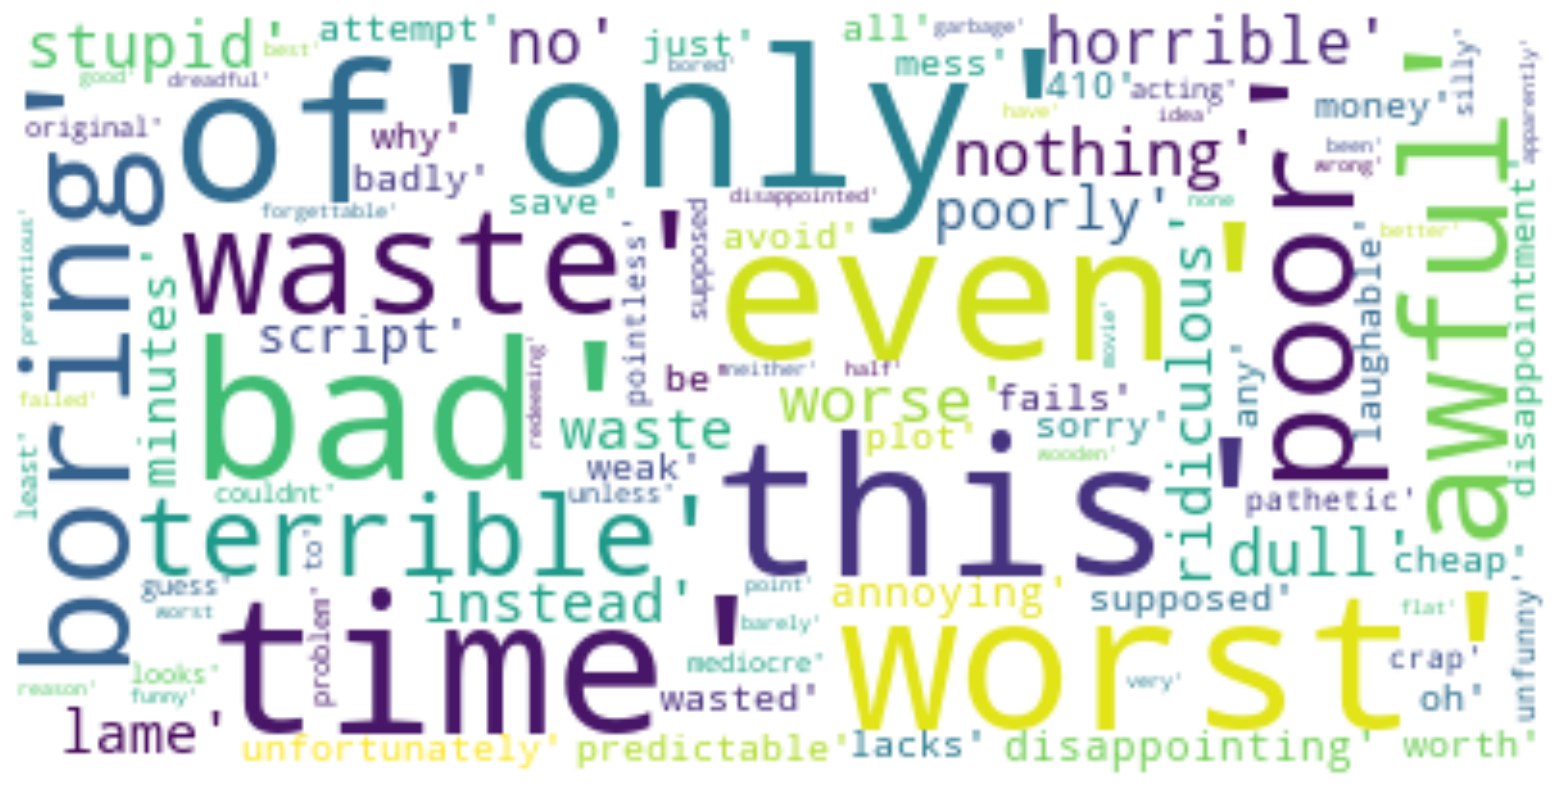

In [32]:
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_words)

# Display the generated image
plt.figure(figsize=(20,10))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

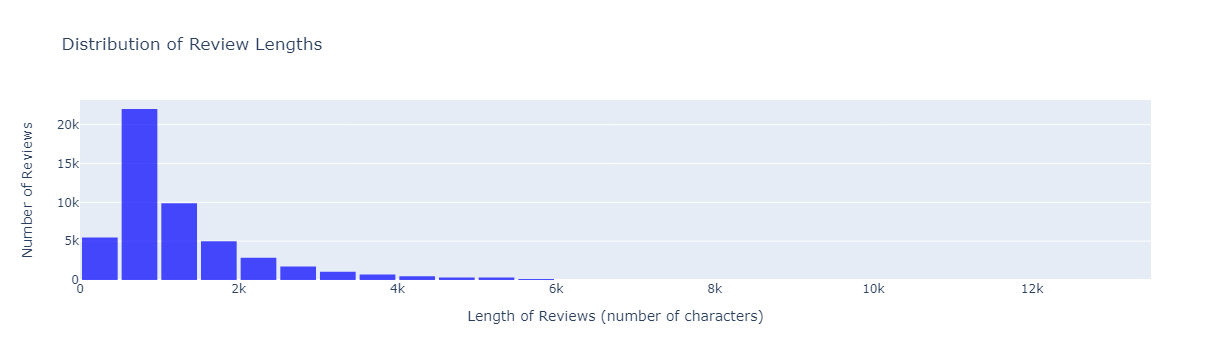

In [33]:
# Calculate the length of each review
movie_reviews['review_length'] = movie_reviews['review'].apply(len)

# Create an interactive histogram to visualize the distribution of review lengths
review_length_dist = px.histogram(movie_reviews, x='review_length',
                   nbins=50,  # Number of bins
                   title='Distribution of Review Lengths',
                   labels={'review_length': 'Length of Reviews (number of characters)'},
                   opacity=0.7,  # Set the opacity of the bars
                   color_discrete_sequence=['blue'])  # Color of the bars

# Update plot layout to include labels and adjust the gap between histogram bars
review_length_dist.update_layout(
    xaxis_title='Length of Reviews (number of characters)',  # X-axis label
    yaxis_title='Number of Reviews',  # Y-axis label
    bargap=0.1  # Gap between bars
)

review_length_dist.show()

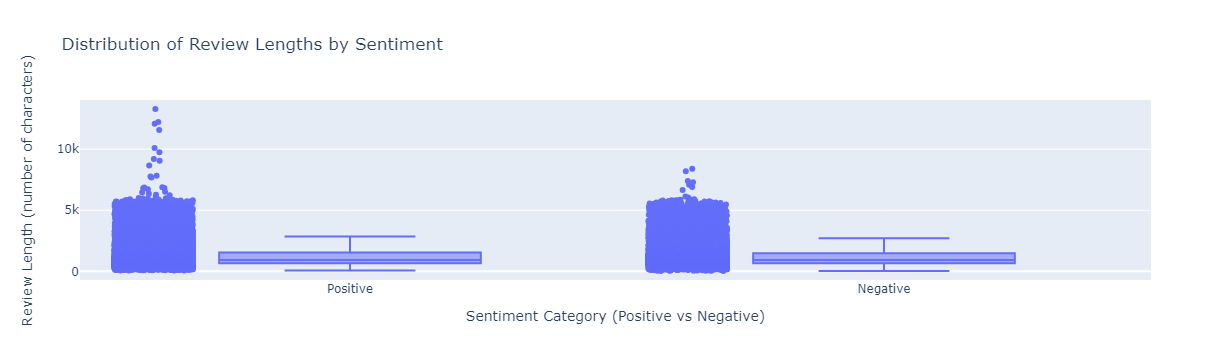

In [34]:
# Convert binary sentiment labels (0, 1) to their string equivalents ('Negative', 'Positive') for clarity in plots and analysis.
movie_reviews['sentiment_label'] = movie_reviews['sentiment'].map({0: 'Negative', 1: 'Positive'})

# Creating an interactive box plot for review lengths by sentiment
review_length_box = px.box(movie_reviews, x='sentiment_label', y='review_length',
             points="all",  # This will also plot all data points as overlay
             labels={'sentiment_label': 'Sentiment Category', 'review_length': 'Review Length (number of characters)'},
             title="Distribution of Review Lengths by Sentiment")

# Update plot to include more detailed method settings and axis titles
review_length_box.update_traces(quartilemethod="inclusive")  # This method includes all data points between Q1 (25th percentile) and Q3 (75th percentile) within the whiskers
review_length_box.update_layout(
    xaxis_title="Sentiment Category (Positive vs Negative)",  # Custom X-axis title
    yaxis_title="Review Length (number of characters)",  # Custom Y-axis title
)
review_length_box.show()

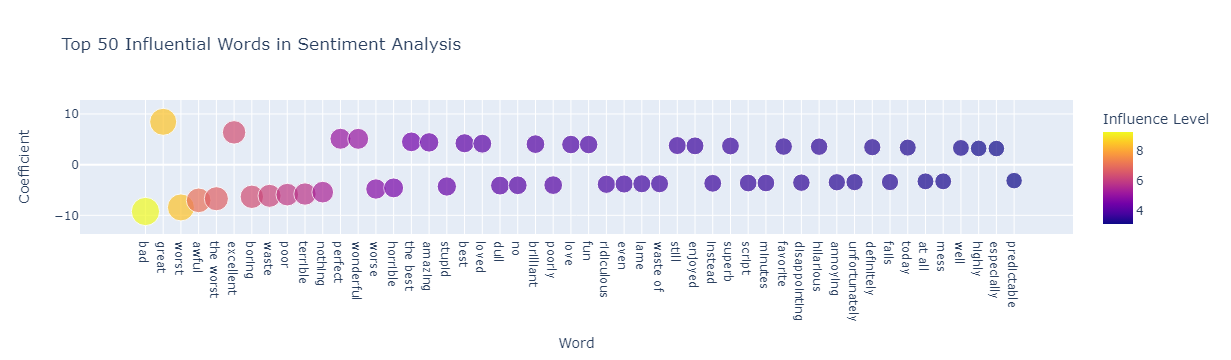

In [35]:
# Convert the dictionary to a DataFrame for easier manipulation and analysis.
coef_df = pd.DataFrame(list(feature_to_coef.items()), columns=['Word', 'Coefficient'])

# Calculate the absolute values of coefficients to assess the magnitude of influence regardless of direction (positive/negative).
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()

# Sorting the DataFrame by the absolute value of the coefficients to get the top 50 most influential words
top_coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).head(50)

# Creating an interactive scatter plot
# The plot sizes points by the absolute coefficient value and colors them based on the magnitude, 
# providing a visual representation of each word's impact on sentiment analysis.
impact_scatter_plot = px.scatter(top_coef_df, x='Word', y='Coefficient', color='Absolute Coefficient',
                 size='Absolute Coefficient', hover_data=['Word'],
                 title='Top 50 Influential Words in Sentiment Analysis',
                 labels={'Word': 'Word', 'Coefficient': 'Coefficient', 'Absolute Coefficient': 'Influence Level'})

impact_scatter_plot.show()

In [36]:
# Prediction function to determine if a review is positive or negative
def predict_review_sentiment(text):
    # Clean and preprocess the text by removing HTML and special characters.
    text = clean_text(text)
    text = remove_special_characters(text)

    # Transform the text with the same TfidfVectorizer used during training
    text_vector = tf_vec.transform([text])

    # Use the trained logistic regression model to predict the sentiment.
    sentiment_prediction = trained_model.predict(text_vector)

    # Convert the binary prediction (0 or 1) back to a human-readable label ('Negative' or 'Positive').
    sentiment = 'Positive' if sentiment_prediction[0] == 1 else 'Negative'
    return sentiment

In [76]:
# Ask the user to input a review
user_review = input("Enter a review to analyze its sentiment: ")

# Use the prediction function to determine the sentiment
review_sentiment = predict_review_sentiment(user_review)

print(f"The predicted sentiment of the review is: {review_sentiment}")

# Example review to input: 1. That movie wasn't good
#                          2. That movie was AMAZING!

Enter a review to analyze its sentiment:  That movie was AMAZING!


The predicted sentiment of the review is: Positive
